# ART - Adversarial Patch - TensorFlow v1

In [8]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
sess = tf.InteractiveSession()
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowClassifier
from art.attacks.evasion import AdversarialPatch

# Settings

In [9]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

# Model definition

In [15]:
%%capture
_image_input = tf.keras.Input(shape=image_shape)
_target_ys = tf.placeholder(tf.float32, shape=(None, nb_classes))
model = tf.keras.applications.resnet50.ResNet50(input_tensor=_image_input, weights='imagenet')
_logits = model.outputs[0].op.inputs[0]
target_loss = tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits)

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowClassifier(clip_values=clip_values, input_ph=_image_input, labels_ph=_target_ys,
                           output=_logits, sess=sess, loss=target_loss,
                           preprocessing=(np.array([mean_b, mean_g, mean_r]), np.array([1.0, 1.0, 1.0])))

# Imagenet training images

In [16]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [17]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

# Adversarial patch generation

In [18]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

Adversarial Patch Numpy:   0%|          | 0/500 [00:00<?, ?it/s]

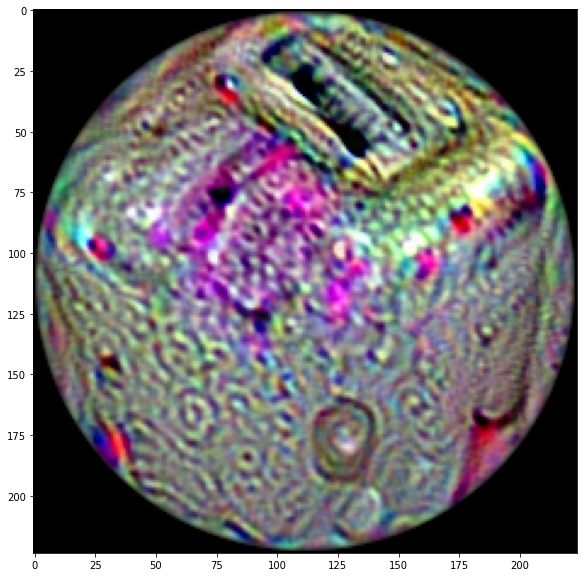

In [19]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

# Evaluation

In [20]:
patched_images = ap.apply_patch(images, scale=0.5)

In [21]:
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

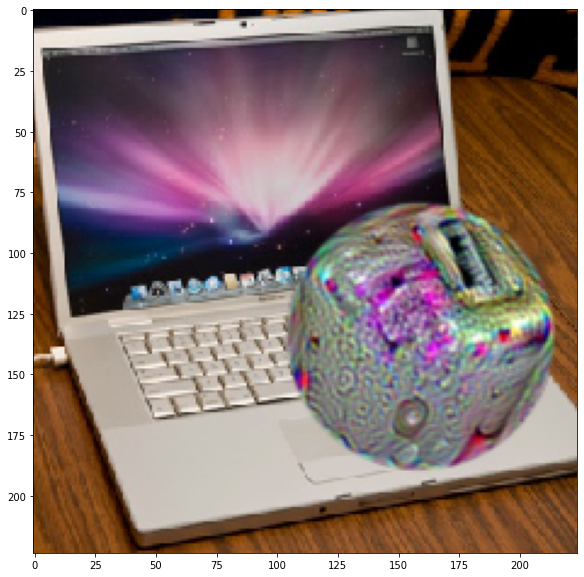

40960/35363 [==================================] - 0s 0us/step
Predictions:
toaster    24.49
mouse      15.94
notebook   14.25
laptop     14.23
piggy_bank 12.70


In [22]:
predict_model(tfc, patched_images[0])

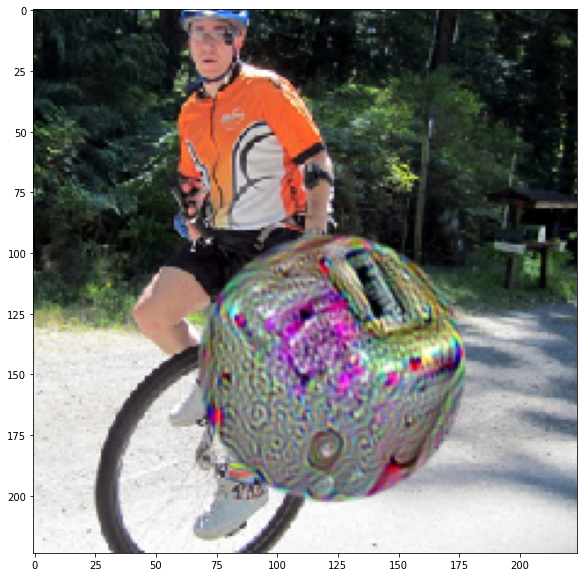

Predictions:
toaster      25.40
piggy_bank   12.49
crash_helmet 9.44
cowboy_hat   9.16
teapot       8.32


In [23]:
predict_model(tfc, patched_images[1])

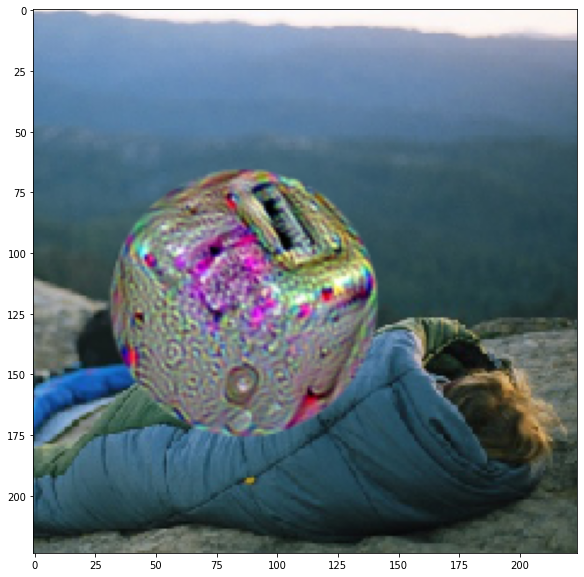

Predictions:
toaster       38.25
piggy_bank    14.53
binoculars    10.20
teapot        9.78
parking_meter 9.63


In [24]:
predict_model(tfc, patched_images[2])